## Downloading the data

Make sure you have the Kaggle CLI installed. You can find the directions for how to set it up [here](https://github.com/Kaggle/kaggle-api).

In [1]:
!mkdir -p data
!mkdir -p data/raw_data

Downloading the dataset can take a while... its over 150GB!

The following will download the dataset for you but it is going to be extremely slow (for most competitions using the kaggle cli works really well - here they set it up so that files are downloaded one by one?!).

What I would recommend is to download all the files in a zip archive using the `Download All` button from the competition website. Once done, extract all the files into `data/raw_data` and we can take it from there.

In [2]:
# !kaggle competitions download -c rsna-intracranial-hemorrhage-detection -p data/raw_data

Let's also download a csv file with train labels and the sample submission.

In [3]:
!cd data && kaggle competitions download -c rsna-intracranial-hemorrhage-detection -f stage_1_sample_submission.csv
!cd data && kaggle competitions download -c rsna-intracranial-hemorrhage-detection -f stage_1_train.csv    

stage_1_sample_submission.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
stage_1_train.csv.zip: Skipping, found more recently modified local copy (use --force to force download)


## Preprocessing the data

Images are saved in DICOM format. Among other things, we will need pydicom to read the data.

The DICOM format has a couple of gotchas - this [kernel](https://www.kaggle.com/omission/eda-view-dicom-images-with-correct-windowing) on kaggle is a good starting point.

We will iterate over all the images in raw_data, process them slightly and save them as image files.

For the window and width values we will use the brain window values that are commonly used for visualizing [intracranial hemorrhages](https://www.kaggle.com/c/rsna-intracranial-hemorrhage-detection/discussion/109328#latest-629856).

In [4]:
%matplotlib inline

import PIL
import pydicom
import numpy as np
from pathlib import Path
from matplotlib import pyplot as plt

import torch
import fastai
from fastai.core import parallel

In [5]:
torch.__version__, fastai.__version__

('1.2.0', '1.0.58.dev0')

In [6]:
window_center = 40
window_width = 80

In [7]:
paths = Path('data/raw_data/stage_1_train_images/')
path = list(paths.iterdir())[0]

In [8]:
im = pydicom.read_file(str(path))

In [9]:
def window_and_normalize(im):
    rescaled = im.pixel_array * float(im.RescaleSlope) + float(im.RescaleIntercept)
    windowed = rescaled.clip(min=window_center-window_width, max=window_center+window_width)

    return (windowed + np.negative(window_center-window_width)) / (window_width * 2 * 1/255)

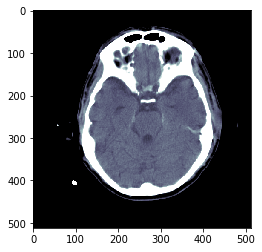

In [10]:
plt.imshow(window_and_normalize(im), cmap=plt.cm.bone)

Let's read the data, process it, resize and save to disk

In [11]:
!mkdir -p data/112
!mkdir -p data/112/train 
!mkdir -p data/112/test 

In [14]:
def resize(src, dst, sz):
    im = pydicom.read_file(str(src))
    ary = window_and_normalize(im)
    im = PIL.Image.fromarray(ary.astype(np.int8), mode='L')
    im.resize((sz,sz), resample=PIL.Image.BICUBIC).save(f'{dst}/{src.stem}.png')

In [13]:
def resize_112(path, _): resize(path, 'data/112/train', 112)

In [14]:
parallel(resize_112, list(paths.iterdir()), max_workers=12)

ValueError: The length of the pixel data in the dataset (153710 bytes) doesn't match the expected length (524288 bytes). The dataset may be corrupted or there may be an issue with the pixel data handler.

Something, somewhere, went wrong :). Looks like one of the files is damaged.

Consulting the forums seems we have the [culprit](https://www.kaggle.com/c/rsna-intracranial-hemorrhage-detection/discussion/109476#latest-629906).

In [20]:
ls data/112/train/ID_6431af929.png

ls: cannot access 'data/112/ID_6431af929.png': No such file or directory


In [35]:
import pandas as pd

df = pd.read_csv('data/stage_1_train.csv.zip')
df[df.ID.str.match('ID_6431af929')]

,ID,Label
3872988,ID_6431af929_epidural,0
3872989,ID_6431af929_intraparenchymal,0
3872990,ID_6431af929_intraventricular,0
3872991,ID_6431af929_subarachnoid,0
3872992,ID_6431af929_subdural,0
3872993,ID_6431af929_any,0


The file is conveniently in the train set. Let's drop it and call it a success.

In [36]:
df = df[~df.ID.str.match('ID_6431af929')]
df.to_csv('data/stage_1_train_with_one_image_dropped.csv', index=False)

In [37]:
!ls data/112 -l | wc -l

674258


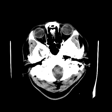

In [38]:
PIL.Image.open('data/112/train/ID_000039fa0.png')

We now need to do the same thing for the images in the test set.

In [12]:
paths = Path('data/raw_data/stage_1_test_images/')

def resize_112(path, _): resize(path, 'data/112/test', 112)

In [15]:
parallel(resize_112, list(paths.iterdir()), max_workers=12)